## Road Centerlines Event and No Traffic
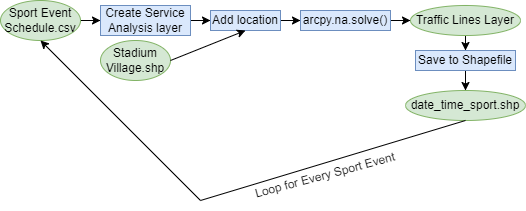

Credits: chat.openai.com and draw.io

### Import Statments

In [ ]:
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath) + '\\final_files'
os.chdir(file_path)
arcpy.env.workspace = file_path
print(arcpy.env.workspace)
import csv
import re
from datetime import datetime

## Adding in Stadium Village Shapefile

In [2]:
#define the location for the analysis
facility = (-93.2265955, 44.9754918) #near stadiums
#name of the new shapefile
shapefile = "Stadium_Village.shp"
#set spatial reference
spatial_ref = arcpy.SpatialReference(4326)
#create the point shapefile
dest_point = arcpy.CreateFeatureclass_management(arcpy.env.workspace, shapefile, "POINT", spatial_reference=spatial_ref)
#create a new insert cursor for adding features to the shapefile
with arcpy.da.InsertCursor(shapefile, ["SHAPE@XY"]) as cursor:
    #add the facility point
    cursor.insertRow([facility])

## List of Every Event + Time and Date

In [3]:
#path to the CSV file
csv_file = os.path.join(arcpy.env.workspace, "qaqc_schedule.csv")
#initialize the list
sport_info = []
#read the CSV file and populate the list
with open(csv_file, "r", newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        #parse date and time strings from the CSV using strptime()
        date = datetime.strptime(row["Date"], '%m/%d/%Y').strftime('%m/%d/%Y')
        #adjust format string to handle '8:00 PM' format
        time_format = '%I:%M %p'
        time = datetime.strptime(row["Time"], time_format).strftime('%I:%M:%S %p')
        season = re.sub(r'\s+', '', row["Season"])
        #construct tuple
        entry = (date, time, season)
        #append the tuple to the list
        sport_info.append(entry)
#print the constructed list
print(sport_info)

[('01/06/2013', '06:00:00 PM', 'Basketball'), ('01/17/2013', '06:00:00 PM', 'Basketball'), ('01/29/2013', '08:00:00 PM', 'Basketball'), ('02/03/2013', '12:00:00 PM', 'Basketball'), ('02/10/2013', '05:00:00 PM', 'Basketball'), ('02/14/2013', '06:00:00 PM', 'Basketball'), ('02/26/2013', '06:00:00 PM', 'Basketball'), ('03/02/2013', '02:00:00 PM', 'Basketball'), ('11/01/2013', '07:00:00 PM', 'Basketball'), ('11/04/2013', '07:00:00 PM', 'Basketball'), ('11/08/2013', '07:00:00 PM', 'Basketball'), ('11/12/2013', '07:00:00 PM', 'Basketball'), ('11/19/2013', '07:00:00 PM', 'Basketball'), ('11/21/2013', '06:00:00 PM', 'Basketball'), ('12/03/2013', '08:30:00 PM', 'Basketball'), ('12/07/2013', '02:00:00 PM', 'Basketball'), ('12/10/2013', '07:00:00 PM', 'Basketball'), ('12/20/2013', '08:00:00 PM', 'Basketball'), ('12/28/2013', '07:30:00 PM', 'Basketball'), ('01/02/2014', '06:00:00 PM', 'Basketball'), ('01/05/2014', '01:30:00 PM', 'Basketball'), ('01/16/2014', '08:00:00 PM', 'Basketball'), ('01/22/2

## Creating Roadlines for Each Event

In [5]:
#list of date/times
sportlist = sport_info   
#continue with the rest of the script (change for each sporting event)
for event in sportlist:
    if event[2] == 'Volleyball':
        #retrieve traffic information for the current date/time from the dictionary
        date_string = re.sub(r'/', '', event[0])
        time_string = re.sub(r'[:,\s]', '', event[1])
        name = f"{date_string}_{time_string}_{event[2]}"
        if not event:
            #handle cases where the date/time is not found in the dictionary
            print(f"No traffic information found for date/time: {time}")
            continue

        #make Service Area Analysis Layer
        layer = arcpy.na.MakeServiceAreaAnalysisLayer(
            network_data_source="https://www.arcgis.com/",
            layer_name=name,
            travel_mode="Driving Time",
            travel_direction="TO_FACILITIES",
            cutoffs=[10],
            time_of_day=f"{event[0]} {event[1]}",
            time_zone="LOCAL_TIME_AT_LOCATIONS",
            output_type="LINES",
            polygon_detail="STANDARD",
            geometry_at_overlaps="OVERLAP",
            geometry_at_cutoffs="RINGS",
            polygon_trim_distance="100 Meters",
            exclude_sources_from_polygon_generation=None,
            accumulate_attributes=None,
            ignore_invalid_locations="SKIP"
        ).getOutput(0)

        #adding location to the layer
        arcpy.na.AddLocations(
            in_network_analysis_layer=layer,
            sub_layer="Facilities",
            in_table=dest_point,
            field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
            search_tolerance="20000 Meters",
            sort_field=None,
            search_criteria="main.Routing_Streets SHAPE",
            match_type="MATCH_TO_CLOSEST",
            append="APPEND",
            snap_to_position_along_network="NO_SNAP",
            snap_offset="5 Meters",
            exclude_restricted_elements="EXCLUDE",
            search_query=None,
            allow_auto_relocate="ALLOW"
        )

        arcpy.na.Solve(layer)
        out = os.path.join(arcpy.env.workspace, f"\\outputs\\{name}.shp")
        sublayer = arcpy.na.GetNASublayer(layer, "SALines")
        arcpy.management.CopyFeatures(sublayer, out)
        print(f"{name} at {datetime.now()}")

09062013_073000PM_Volleyball at 2024-03-24 14:54:41.170509
09072013_010000PM_Volleyball at 2024-03-24 14:55:19.736076
09072013_073000PM_Volleyball at 2024-03-24 14:56:04.808102
09252013_063000PM_Volleyball at 2024-03-24 14:56:41.835514
09292013_010000PM_Volleyball at 2024-03-24 14:57:28.879978
10172013_070000PM_Volleyball at 2024-03-24 14:58:10.980858
10192013_070000PM_Volleyball at 2024-03-24 14:58:48.874234
10272013_010000PM_Volleyball at 2024-03-24 14:59:29.500716
11082013_070000PM_Volleyball at 2024-03-24 15:00:05.651597
11102013_033000PM_Volleyball at 2024-03-24 15:00:46.189246
11152013_070000PM_Volleyball at 2024-03-24 15:01:21.301750
11162013_073000PM_Volleyball at 2024-03-24 15:02:02.389615
11272013_070000PM_Volleyball at 2024-03-24 15:02:39.137452
12062013_070000PM_Volleyball at 2024-03-24 15:03:22.556541
12072013_070000PM_Volleyball at 2024-03-24 15:03:59.476132
08292014_070000PM_Volleyball at 2024-03-24 15:04:34.814324
08302014_070000PM_Volleyball at 2024-03-24 15:05:11.3982

## Prints Results

In [9]:
for event in sportlist[462:]:
    print(event)

('01/16/2023', '05:00:00 PM', 'Basketball')
('01/19/2023', '06:00:00 PM', 'Basketball')
('01/25/2023', '08:00:00 PM', 'Basketball')
('02/04/2023', '08:00:00 PM', 'Basketball')
('02/12/2023', '12:00:00 PM', 'Basketball')
('02/18/2023', '08:00:00 PM', 'Basketball')
('03/02/2023', '06:00:00 PM', 'Basketball')
('03/05/2023', '06:30:00 PM', 'Basketball')
('08/18/2023', '06:00:00 PM', 'Volleyball')
('08/25/2023', '07:00:00 PM', 'Volleyball')
('08/26/2023', '07:00:00 PM', 'Volleyball')
('08/29/2023', '07:00:00 PM', 'Volleyball')
('09/14/2023', '07:00:00 PM', 'Volleyball')
('09/16/2023', '04:30:00 PM', 'Volleyball')
('09/29/2023', '06:00:00 PM', 'Volleyball')
('09/30/2023', '08:00:00 PM', 'Volleyball')
('10/15/2023', '12:30:00 PM', 'Volleyball')
('10/20/2023', '07:00:00 PM', 'Volleyball')
('10/22/2023', '02:00:00 PM', 'Volleyball')
('11/10/2023', '06:00:00 PM', 'Volleyball')
('11/17/2023', '07:00:00 PM', 'Volleyball')
('11/18/2023', '07:00:00 PM', 'Volleyball')
('11/24/2023', '05:30:00 PM', 'V